## DataSet Import

In [511]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [1024]:
df_train = pd.read_csv('angles_train.csv')
df_val = pd.read_csv('angles_val.csv')
df_test = pd.read_csv('angles_test.csv')

In [1025]:
df_train.shape, df_val.shape, df_test.shape

((50471, 23), (17848, 23), (4385, 23))

In [1026]:
df_train['label'].unique()

array(['barbell biceps curl', 'bench press', 'chest fly machine',
       'deadlift', 'decline bench press', 'hammer curl', 'hip thrust',
       'incline bench press', 'lat pulldown', 'lateral raise',
       'leg extension', 'leg raises', 'plank', 'pull Up', 'push-up',
       'romanian deadlift', 'russian twist', 'shoulder press', 'squat',
       't bar row', 'tricep dips', 'tricep Pushdown', 'no_exercise'],
      dtype=object)

In [1023]:
# distinct_exercises = [
#     "barbell biceps curl",
#     'deadlift',
#     'lateral raise',
#     'plank',
#     'push-up',
#     'russian twist',
#     'squat',
#     "chest fly machine",
#     'shoulder press',
# ]

distinct_exercises = [
    "barbell biceps curl",
    'hammer curl',
    'deadlift',
    "lat pulldown",
    'lateral raise',
    'plank',
    'push-up',
    'russian twist',
    'squat',
    "chest fly machine",
    'shoulder press',
    'no_exercise'
]

df_train = df_train[df_train['label'].isin(distinct_exercises)]
df_val = df_val[df_val['label'].isin(distinct_exercises)]
df_test = df_test[df_test['label'].isin(distinct_exercises)]

In [954]:
df_train.shape, df_val.shape, df_test.shape

((27195, 23), (9505, 23), (2372, 23))

In [1027]:
def add_temporal_features(df):
    # Group by video_id to maintain temporal continuity
    grouped = df.groupby('video_id')

    # For each feature, calculate velocity and acceleration
    feature_cols = [col for col in df.columns if col not in ['video_id', 'label']]

    for col in feature_cols:
        # First derivative (velocity)
        df[f'{col}_vel'] = grouped[col].diff()

        # Second derivative (acceleration)
        df[f'{col}_acc'] = grouped[f'{col}_vel'].diff()

        # Jerk (rate of change of acceleration)
        df[f'{col}_jerk'] = grouped[f'{col}_acc'].diff()

    return df

df_train = add_temporal_features(df_train)
df_val = add_temporal_features(df_val)
df_test = add_temporal_features(df_test)

In [1028]:
def add_phase_features(df):
    # Identify exercise phases (concentric, eccentric, transition)
    grouped = df.groupby('video_id')

    # For key features, identify phases
    key_features = ['torso_lean', 'elbow_symmetry', 'hip_angle']

    for feature in key_features:
        # Calculate local minima and maxima to identify phases
        df[f'{feature}_local_min'] = grouped[feature].transform(
            lambda x: x == x.rolling(window=5, center=True).min()
        )
        df[f'{feature}_local_max'] = grouped[feature].transform(
            lambda x: x == x.rolling(window=5, center=True).max()
        )

        # Phase indicator (0: eccentric, 1: concentric, 2: transition)
        df[f'{feature}_phase'] = 0
        df.loc[df[f'{feature}_local_min'], f'{feature}_phase'] = 2  # Transition
        df.loc[df[f'{feature}_local_max'], f'{feature}_phase'] = 2  # Transition

        # Fill concentric phases
        for vid in df['video_id'].unique():
            vid_mask = df['video_id'] == vid
            vid_data = df[vid_mask].copy()

            # Find transitions and fill between them
            transitions = vid_data[vid_data[f'{feature}_phase'] == 2].index
            if len(transitions) >= 2:
                for i in range(0, len(transitions)-1, 2):
                    start_idx = transitions[i]
                    end_idx = transitions[i+1]
                    df.loc[vid_mask & (df.index >= start_idx) & (df.index <= end_idx), f'{feature}_phase'] = 1

    return df

In [1029]:
df_train = add_phase_features(df_train)
df_val = add_phase_features(df_val)
df_test = add_phase_features(df_test)

In [1030]:
df_train.shape, df_val.shape, df_test.shape

((50471, 95), (17848, 95), (4385, 95))

In [683]:
df_train['label'].value_counts()

,count
label,
plank,3347
squat,3317
hammer curl,2919
barbell biceps curl,2853
push-up,2632
t bar row,2444
chest fly machine,2262
deadlift,1879
russian twist,1634


## Preprocessing

In [1031]:
def clean_data(df):
    numeric_cols = df.select_dtypes(include=np.number).columns

    df[numeric_cols] = df.groupby('video_id')[numeric_cols].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

In [1032]:
def remove_zero_frames(df):
    angle_cols = [col for col in df.columns if col not in ["label", "video_id", "Unnamed: 0"]]
    return df[(df[angle_cols].sum(axis=1) != 0)]

In [1033]:
def clip_outliers_by_exercise(df):
    processed_groups = []
    grouped = df.groupby('label')

    for _, group in grouped:
        cols_to_process = group.select_dtypes(include=np.number).columns
        modified_group = group.copy()

        for column in cols_to_process:
            Q1 = modified_group[column].quantile(0.25)
            Q3 = modified_group[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            modified_group[column] = modified_group[column].clip(lower=lower_bound, upper=upper_bound)

        processed_groups.append(modified_group)

    return pd.concat(processed_groups, ignore_index=True)

In [1034]:
def preprocess_dataset(df):
    df = clean_data(df)

    df = remove_zero_frames(df)

    df = clip_outliers_by_exercise(df)

    return df

In [1035]:
df_train = preprocess_dataset(df_train)
df_val = preprocess_dataset(df_val)
df_test = preprocess_dataset(df_test)

/tmp/ipython-input-3759811462.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3759811462.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-3759811462.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3759811462.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-3759811462.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffil

In [1036]:
df_train.shape, df_val.shape, df_test.shape

((50471, 95), (17848, 95), (4385, 95))

## Plotting

In [1037]:
from matplotlib import pyplot as plt
import seaborn as sns

In [1038]:
exercises = df_train['label'].unique()

In [1039]:
angle_columns = [col for col in df_train.columns if col not in ['label','video_id']]

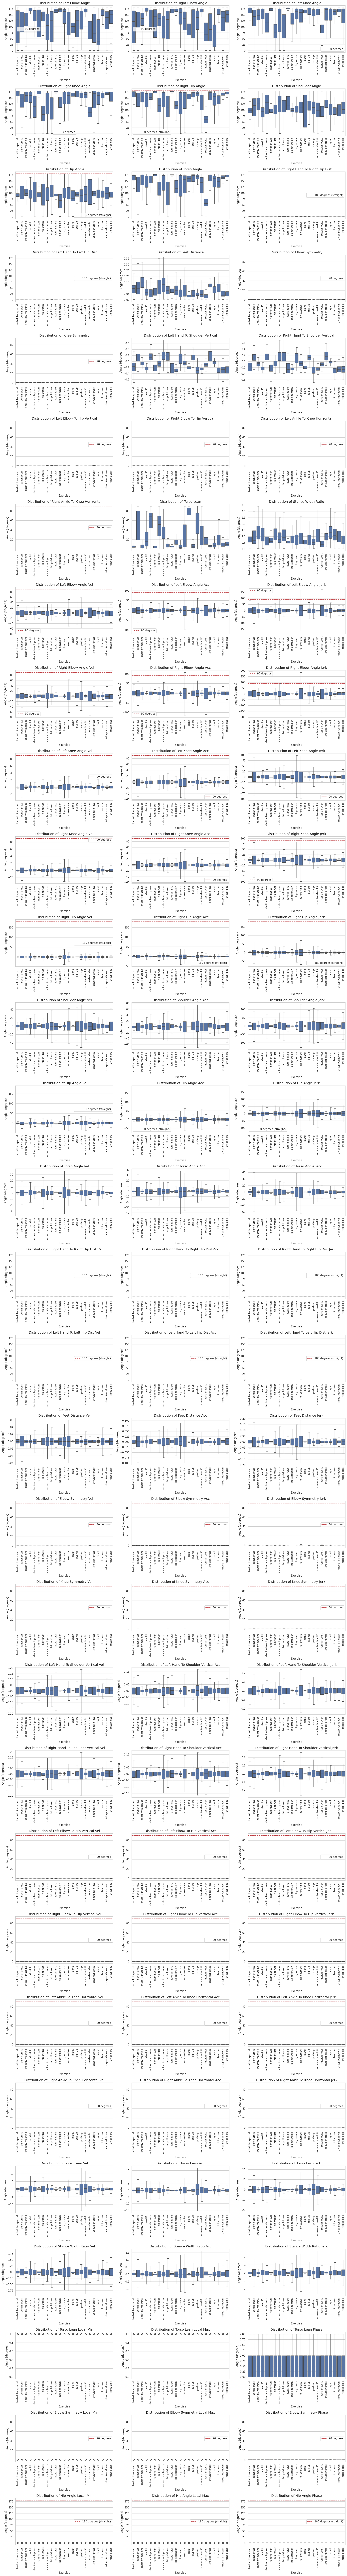

In [1040]:
sns.set(style="whitegrid")

num_angles = len(angle_columns)
cols = 3
rows = (num_angles + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows))
axes = axes.flatten() if rows > 1 or cols > 1 else [axes]

for i, angle_name in enumerate(angle_columns):
    ax = axes[i]

    sns.boxplot(x='label', y=angle_name, data=df_train, ax=ax)

    ax.set_title(f'Distribution of {angle_name.replace("_", " ").title()}', fontsize=14)
    ax.set_xlabel('Exercise', fontsize=12)
    ax.set_ylabel('Angle (degrees)', fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=10)

    if "elbow" in angle_name or "knee" in angle_name:
         ax.axhline(y=90, color='r', linestyle='--', linewidth=1.5, label='90 degrees')
         ax.legend()
    elif "hip" in angle_name:
        ax.axhline(y=180, color='r', linestyle='--', linewidth=1.5, label='180 degrees (straight)')
        ax.legend()

for i in range(len(angle_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## Reshaping Data

In [1041]:
seq_length = 25
overlap= 13

In [1042]:
def create_sequences_by_video(df, seq_length, overlap):
    X, y = [], []
    grouped_by_video = df.groupby(['label', 'video_id'])

    for (label, video_id), group in tqdm(grouped_by_video, desc="Creating Sequences"):
        data = group.drop(['label', 'video_id'], axis=1).values
        if len(data) < seq_length:
            continue

        for i in range(0, len(data) - seq_length + 1, seq_length - overlap):
            X.append(data[i:i + seq_length])
            y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [1069]:
X_train, y_train_str = create_sequences_by_video(df_train, seq_length, overlap)
X_val, y_val_str = create_sequences_by_video(df_val, seq_length, overlap)
X_test, y_test_str = create_sequences_by_video(df_test, seq_length, overlap)

Creating Sequences: 100%|██████████| 55/55 [00:00<00:00, 345.23it/s]


In [1070]:
X_train.shape, X_val.shape, X_test.shape

((2278, 25, 93), (916, 25, 93), (283, 25, 93))

## Resampling

In [1071]:
from imblearn.over_sampling import RandomOverSampler
n_sequences = X_train.shape[0]
X_train_flat = X_train.reshape(n_sequences, -1)

In [1072]:
ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_train_resampled_flat, y_train_resampled = ros.fit_resample(X_train_flat, y_train_str)

In [1073]:
X_train_resampled = X_train_resampled_flat.reshape(-1, seq_length, X_train.shape[2])

In [1074]:
X_train_resampled.shape, y_train_resampled.shape

((4715, 25, 93), (4715,))

In [1075]:
X_train = X_train_resampled
y_train_str = y_train_resampled

## Augmentation

In [923]:
def augment_sequences(X, y, n_augments=1):
    X_augmented_list = [X]
    y_augmented_list = [y]

    for _ in range(n_augments):
        X_aug = X.copy()

        # Jittering (Adding Gaussian Noise)
        noise = np.random.normal(0, 0.05, X_aug.shape)
        X_aug += noise

        # Scaling
        scale_factor = np.random.uniform(0.9, 1.1, size=(X_aug.shape[0], 1, 1))
        X_aug *= scale_factor

        X_augmented_list.append(X_aug)
        y_augmented_list.append(y)

    X_augmented = np.concatenate(X_augmented_list, axis=0)
    y_augmented = np.concatenate(y_augmented_list, axis=0)

    return X_augmented, y_augmented


In [536]:
X_train_aug, y_train_aug_str = augment_sequences(X_train, y_train_str, n_augments=2)

In [537]:
X_train_aug.shape

(6120, 25, 16)

In [1076]:
def light_augment_sequences(X, y, n_augments=1):
    """
    Apply light augmentations to sequences for validation set
    """
    X_augmented_list = [X]
    y_augmented_list = [y]

    for _ in range(n_augments):
        X_aug = X.copy()

        # Very light Gaussian noise (much lighter than training)
        noise = np.random.normal(0, 0.01, X_aug.shape)  # std=0.01 (vs 0.05 for training)
        X_aug += noise

        # Very slight scaling (narrower range than training)
        scale_factor = np.random.uniform(0.99, 1.01, size=(X_aug.shape[0], 1, 1))
        X_aug *= scale_factor

        X_augmented_list.append(X_aug)
        y_augmented_list.append(y)

    X_augmented = np.concatenate(X_augmented_list, axis=0)
    y_augmented = np.concatenate(y_augmented_list, axis=0)
    return X_augmented, y_augmented

X_val_aug, y_val_aug_str = light_augment_sequences(X_val, y_val_str, n_augments=1)

In [1077]:
X_val_aug.shape

(1832, 25, 93)

In [ ]:
from scipy.interpolate import interp1d
def augment_sequences_robust(X, y, n_augments=2):
    X_augmented_list = [X]
    y_augmented_list = [y]

    for _ in range(n_augments):
        X_aug = X.copy()

        # 1. Jittering (Adds random noise)
        noise = np.random.normal(0, 0.05, X_aug.shape)
        X_aug += noise

        # 2. Scaling (Simulates body size or camera distance changes)
        scale_factor = np.random.uniform(0.9, 1.1, size=(X_aug.shape[0], 1, 1))
        X_aug *= scale_factor

        # 3. Random Rotation (Simulates pose variations)
        # Note: This is a simple 2D rotation. For 3D skeleton data, a more complex 3D rotation matrix would be needed.
        angle_rad = np.random.uniform(-0.1, 0.1, size=(X_aug.shape[0], 1, 1))  # +/- ~5.7 degrees
        cos_val = np.cos(angle_rad)
        sin_val = np.sin(angle_rad)

        # Apply a 2D rotation matrix to each frame of each sequence
        for i in range(X_aug.shape[0]):
            rotation_matrix = np.array([[cos_val[i], -sin_val[i]],
                                        [sin_val[i],  cos_val[i]]]).squeeze()

            # Assuming features are structured as pairs (e.g., x, y coordinates).
            # If you are using angles/distances, you can skip this step or apply a different type of rotation.
            for j in range(X_aug.shape[2] // 2):
                original_xy = X_aug[i, :, 2*j:2*j+2]
                rotated_xy = np.dot(original_xy, rotation_matrix)
                X_aug[i, :, 2*j:2*j+2] = rotated_xy

        # 4. Time Warping (Simulates speed changes)
        for i in range(X_aug.shape[0]):
            seq_len = X_aug.shape[1]
            time_points = np.linspace(0, 1, seq_len)

            # Create random time points for warping
            warp_points = np.sort(np.random.uniform(0, 1, size=2))
            warp_factor = np.random.uniform(0.8, 1.2, size=1)

            # Warp the sequence
            warped_time_points = time_points.copy()
            warped_time_points[np.where((time_points >= warp_points[0]) & (time_points <= warp_points[1]))] *= warp_factor

            # Interpolate to get the new sequence
            interp_func = interp1d(warped_time_points, X_aug[i, :, :], axis=0, fill_value="extrapolate")
            X_aug[i, :, :] = interp_func(time_points)

        # 5. Feature Masking (Simulates occlusion)
        for i in range(X_aug.shape[0]):
            num_features_to_mask = np.random.randint(0, X_aug.shape[2] // 4)
            if num_features_to_mask > 0:
                mask_features = np.random.choice(X_aug.shape[2], num_features_to_mask, replace=False)

                mask_start = np.random.randint(0, X_aug.shape[1] // 2)
                mask_end = np.random.randint(mask_start, X_aug.shape[1])

                X_aug[i, mask_start:mask_end, mask_features] = 0

        X_augmented_list.append(X_aug)
        y_augmented_list.append(y)

    X_augmented = np.concatenate(X_augmented_list, axis=0)
    y_augmented = np.concatenate(y_augmented_list, axis=0)

    return X_augmented, y_augmented

X_train_aug, y_train_aug_str = augment_sequences_robust(X_train, y_train_str, n_augments=2)

In [ ]:
X_train_aug.shape

### Scaling Data

In [1047]:
from sklearn.preprocessing import StandardScaler
import joblib

In [1048]:
features = [col for col in df_train.columns if col not in ['label', 'video_id']]

In [1049]:
X_train_reshaped = X_train_aug.reshape(-1, X_train_aug.shape[-1])
X_val_reshaped = X_val_aug.reshape(-1, X_val_aug.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

In [1050]:
scaler = StandardScaler()
scaler.fit(X_train_reshaped)

X_train_scaled = scaler.transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

X_train_final = X_train_scaled.reshape(X_train_aug.shape)
X_val_final = X_val_scaled.reshape(X_val_aug.shape)
X_test_final = X_test_scaled.reshape(X_test.shape)

joblib.dump(scaler, 'real_time_scaler.pkl')

['real_time_scaler.pkl']

In [1051]:
print(f"Final X_train shape for GRU: {X_train_final.shape}")
print(f"Final X_val shape for GRU: {X_val_final.shape}")
print(f"Final X_test shape for GRU: {X_test_final.shape}")

Final X_train shape for GRU: (9112, 25, 93)
Final X_val shape for GRU: (978, 25, 93)
Final X_test shape for GRU: (283, 25, 93)


## Encoding

In [1052]:
from sklearn.preprocessing import LabelEncoder

In [1053]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_aug_str)
y_val_encoded = label_encoder.transform(y_val_aug_str)
y_test_encoded = label_encoder.transform(y_test_str)

In [1054]:
import json
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

with open('encoded_labels.json', 'w') as f:
    json.dump(label_mapping, f)

In [1055]:
label_mapping

{0: np.str_('barbell biceps curl'),
 1: np.str_('bench press'),
 2: np.str_('chest fly machine'),
 3: np.str_('deadlift'),
 4: np.str_('decline bench press'),
 5: np.str_('hammer curl'),
 6: np.str_('hip thrust'),
 7: np.str_('incline bench press'),
 8: np.str_('lat pulldown'),
 9: np.str_('lateral raise'),
 10: np.str_('leg extension'),
 11: np.str_('leg raises'),
 12: np.str_('no_exercise'),
 13: np.str_('plank'),
 14: np.str_('pull Up'),
 15: np.str_('push-up'),
 16: np.str_('romanian deadlift'),
 17: np.str_('russian twist'),
 18: np.str_('shoulder press'),
 19: np.str_('squat'),
 20: np.str_('t bar row'),
 21: np.str_('tricep Pushdown'),
 22: np.str_('tricep dips')}

# GRU BUILDING

In [1056]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, BatchNormalization, LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [1057]:
num_features = X_train_aug.shape[2]
num_classes = len(np.unique(y_train_encoded))

# gru_model.h5
# model = Sequential()
# model.add(tf.keras.Input(shape=(seq_length, num_features)))
# model.add(GRU(64, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(GRU(32))
# model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(num_classes, activation='softmax'))

#model_2
# model = Sequential()
# model.add(tf.keras.Input(shape=(seq_length, num_features)))
# model.add(Bidirectional(GRU(64, return_sequences=True)))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(GRU(32))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(num_classes, activation='softmax'))

#model_3 GRU
# model = Sequential()
# model.add(tf.keras.Input(shape=(seq_length, num_features)))
# model.add(Bidirectional(GRU(64, return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(GRU(32))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(num_classes, activation='softmax'))

# model = Sequential()
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(seq_length, num_features)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.3))
# model.add(GRU(64))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

## Transformer Based Model

In [1058]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Dense, GlobalAveragePooling1D

num_features = X_train_aug.shape[2]
num_classes = len(np.unique(y_train_encoded))

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer Normalization and Multi-Head Attention
    # This block processes the input sequence and captures relationships between features at different timesteps.
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x, x) # Corrected: Added the third `x` argument for value
    x = Dropout(dropout)(x)
    res = x + inputs  # Add the original input to the output (residual connection)

    # Feed-Forward Network
    # This block processes the output of the attention mechanism to create a richer representation.
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="gelu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res # Another residual connection

def build_transformer_model(seq_length, num_features, num_classes):
    inputs = tf.keras.Input(shape=(seq_length, num_features))

    # Optional: A starting dense layer to embed the input features.
    x = Dense(num_features, activation="relu")(inputs)

    # Transformer blocks
    # Stacking multiple blocks allows the model to learn more complex patterns.
    for _ in range(2):
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

    # Global pooling and classification
    # Reduces the sequence of features to a single vector for classification.
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

In [1059]:
model = build_transformer_model(seq_length, num_features, num_classes)

In [1060]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [1061]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001,
    mode = 'min'
)

In [1062]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=0.00001,
    verbose=1
)

In [1063]:
model.summary()

Model: "functional_484"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_53      │ (None, 25, 93)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_160 (Dense)   │ (None, 25, 93)    │      8,742 │ input_layer_53[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 25, 93)    │        186 │ dense_160[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 25, 93)    │     96,093 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_223         │ (None, 25, 93)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 25, 93)    │          0 │ dropout_223[0][0… │
│                     │                   │            │ dense_160[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 25, 93)    │        186 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_161 (Dense)   │ (None, 25, 128)   │     12,032 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_224         │ (None, 25, 128)   │          0 │ dense_161[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_162 (Dense)   │ (None, 25, 93)    │     11,997 │ dropout_224[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 25, 93)    │          0 │ dense_162[0][0],  │
│                     │                   │            │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 25, 93)    │        186 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 25, 93)    │     96,093 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_226         │ (None, 25, 93)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 25, 93)    │          0 │ dropout_226[0][0… │
│                     │                   │            │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 25, 93)    │        186 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_163 (Dense)   │ (None, 25, 128)   │     12,032 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 253,497 (990.22 KB)

 Trainable params: 253,497 (990.22 KB)

 Non-trainable params: 0 (0.00 B)

In [1064]:
epochs = 120
batch_size = 32

In [1065]:
history = model.fit(
    X_train_final,
    y_train_encoded,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_final, y_val_encoded),
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/120
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.1465 - loss: 2.9457 - val_accuracy: 0.3793 - val_loss: 1.9470 - learning_rate: 1.0000e-04
Epoch 2/120
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3680 - loss: 2.1491 - val_accuracy: 0.5920 - val_loss: 1.3820 - learning_rate: 1.0000e-04
Epoch 3/120
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4979 - loss: 1.7062 - val_accuracy: 0.6656 - val_loss: 1.1084 - learning_rate: 1.0000e-04
Epoch 4/120
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6164 - loss: 1.3380 - val_accuracy: 0.6840 - val_loss: 1.0346 - learning_rate: 1.0000e-04
Epoch 5/120
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6582 - loss: 1.1146 - val_accuracy: 0.7025 - val_loss: 1.0484 - learning_rate: 1.0000e-04
Epoch 6/120
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7182 - loss: 0.9316 - val_accuracy: 0.7157 - val_loss: 1.0153 - learning_rate: 1.0000e-04
Epoch 7/120
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - a

In [1066]:
feature_names = [col for col in df_train.columns if col not in ['label','video_id']]

In [1067]:
len(feature_names)

93

In [1068]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

def calculate_permutation_importance(model, X_val, y_val_encoded, feature_names):
    print("Calculating baseline accuracy...")
    baseline_predictions = model.predict(X_val, verbose=0)
    baseline_accuracy = accuracy_score(y_val_encoded, np.argmax(baseline_predictions, axis=1))

    print(f"Baseline Validation Accuracy: {baseline_accuracy:.4f}\n")

    feature_importance = {}

    for i, feature in enumerate(feature_names):
        print(f"Permuting feature: '{feature}'...")
        # Make a copy of the validation data to avoid modifying the original
        X_val_shuffled = X_val.copy()

        # Permute the values of the current feature across all timesteps
        original_col = X_val_shuffled[:, :, i].copy()
        np.random.shuffle(original_col)
        X_val_shuffled[:, :, i] = original_col

        # Make predictions on the shuffled data
        shuffled_predictions = model.predict(X_val_shuffled, verbose=0)
        shuffled_accuracy = accuracy_score(y_val_encoded, np.argmax(shuffled_predictions, axis=1))

        # Calculate the importance score (drop in accuracy)
        importance_score = baseline_accuracy - shuffled_accuracy
        feature_importance[feature] = importance_score
        print(f"  Accuracy drop: {importance_score:.4f}")

    importance_df = pd.DataFrame(
        list(feature_importance.items()),
        columns=['feature', 'importance']
    ).sort_values(by='importance', ascending=False)

    return importance_df


importance_results = calculate_permutation_importance(model, X_val_final, y_val_encoded, feature_names)
print("\nFeature Importance Ranking:")
# print(importance_results)

Calculating baseline accuracy...
Baseline Validation Accuracy: 0.7157

Permuting feature: 'left_elbow_angle'...
  Accuracy drop: 0.0031
Permuting feature: 'right_elbow_angle'...
  Accuracy drop: -0.0010
Permuting feature: 'left_knee_angle'...
  Accuracy drop: 0.0051
Permuting feature: 'right_knee_angle'...
  Accuracy drop: 0.0041
Permuting feature: 'right_hip_angle'...
  Accuracy drop: 0.0051
Permuting feature: 'shoulder_angle'...
  Accuracy drop: 0.0010
Permuting feature: 'hip_angle'...
  Accuracy drop: 0.0020
Permuting feature: 'torso_angle'...
  Accuracy drop: 0.0061
Permuting feature: 'right_hand_to_right_hip_dist'...
  Accuracy drop: 0.0061
Permuting feature: 'left_hand_to_left_hip_dist'...
  Accuracy drop: 0.0000
Permuting feature: 'feet_distance'...
  Accuracy drop: 0.0051
Permuting feature: 'elbow_symmetry'...
  Accuracy drop: 0.0000
Permuting feature: 'knee_symmetry'...
  Accuracy drop: 0.0092
Permuting feature: 'left_hand_to_shoulder_vertical'...
  Accuracy drop: -0.0082
Perm

## Evaluating Model

In [949]:
print("Evaluating on test data...")
loss, accuracy = model.evaluate(X_test_final, y_test_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating on test data...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3353 - loss: 3.0037
Test Loss: 3.1742
Test Accuracy: 0.3026


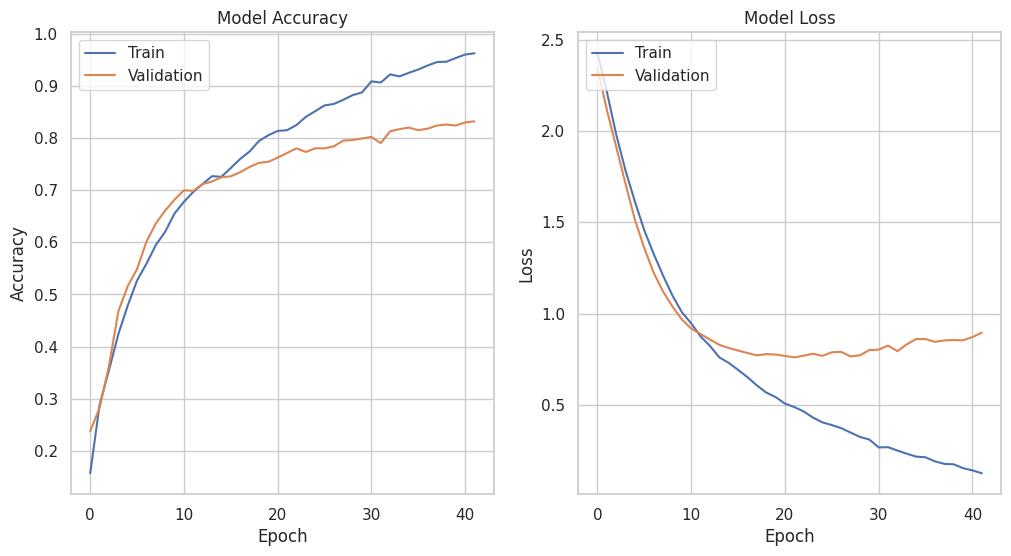

In [831]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [465]:
model.save('GRU_model_4.h5')

## Using ML APPROACH

1.  Random Forest Classifier
2.  Light GBM



In [ ]:
X_train_flat = X_train_final.reshape(X_train_final.shape[0], -1)
X_val_flat = X_val_final.reshape(X_val_final.shape[0], -1)
X_test_flat = X_test_final.reshape(X_test_final.shape[0], -1)

print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened validation data shape: {X_val_flat.shape}")
print(f"Flattened test data shape: {X_test_flat.shape}")

Flattened training data shape: (2379, 300)
Flattened validation data shape: (319, 300)
Flattened test data shape: (99, 300)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

### Using Class Balancing

In [ ]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
rfc = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1 #
)

print("Training Random Forest Classifier...")
rfc.fit(X_train_flat, y_train_encoded)

Training Random Forest Classifier...


RandomForestClassifier(class_weight={0: np.float64(1.6183673469387756),
                                     1: np.float64(0.7812807881773399),
                                     2: np.float64(1.6183673469387756),
                                     3: np.float64(0.6663865546218487),
                                     4: np.float64(1.0025284450063212),
                                     5: np.float64(1.5308880308880308),
                                     6: np.float64(0.750236518448439)},
                       n_jobs=-1, random_state=42)

In [ ]:
val_preds = rfc.predict(X_val_flat)
val_accuracy = accuracy_score(y_val_encoded, val_preds)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.8683


In [ ]:
print("\nValidation Classification Report:")
print(classification_report(y_val_encoded, val_preds))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.33      0.48        33
           1       0.81      0.98      0.89        45
           2       0.96      0.69      0.81        36
           3       0.94      0.92      0.93        51
           4       0.93      1.00      0.96        81
           5       0.95      1.00      0.97        38
           6       0.63      0.89      0.74        35

    accuracy                           0.87       319
   macro avg       0.87      0.83      0.83       319
weighted avg       0.88      0.87      0.86       319



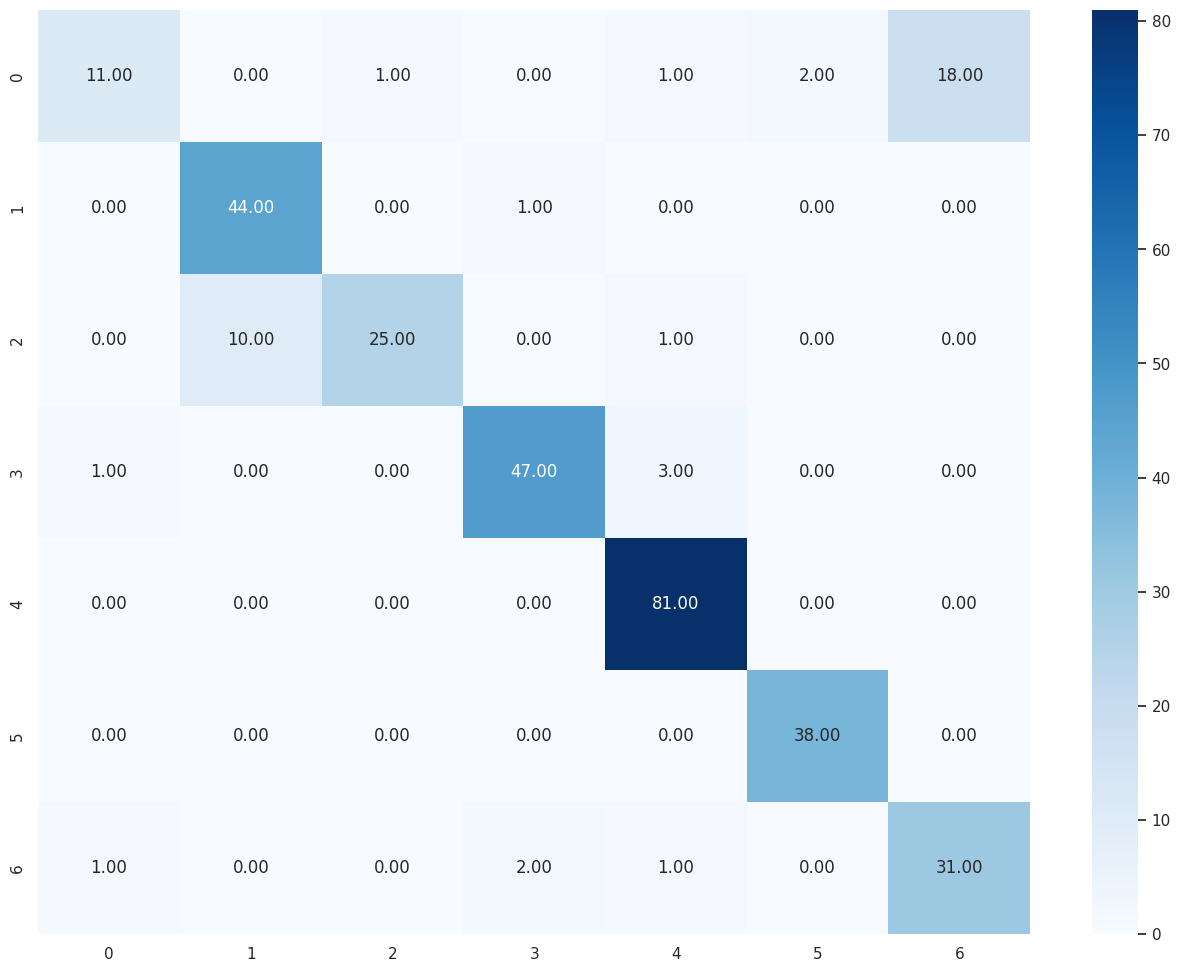

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(confusion_matrix(y_val_encoded, val_preds), cmap='Blues', annot=True, fmt=".2f")
plt.show()

In [ ]:
test_preds = rfc.predict(X_test_flat)
test_accuracy = accuracy_score(y_test_encoded, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.3333


## Light GBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_train_encoded)),
    n_estimators=100,
    learning_rate=0.1,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Training LightGBM Classifier...")
lgb_model.fit(X_train_flat, y_train_encoded)
print("Training complete.")

Training LightGBM Classifier...
Training complete.


In [ ]:
val_preds = lgb_model.predict(X_val_flat)
val_accuracy = accuracy_score(y_val_encoded, val_preds)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print("Validation Classification Report:")
print(classification_report(y_val_encoded, val_preds))


Validation Accuracy: 0.8652
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.33      0.49        33
           1       0.94      1.00      0.97        45
           2       0.94      0.86      0.90        36
           3       0.92      0.94      0.93        51
           4       0.86      0.96      0.91        81
           5       0.78      1.00      0.87        38
           6       0.74      0.71      0.72        35

    accuracy                           0.87       319
   macro avg       0.87      0.83      0.83       319
weighted avg       0.87      0.87      0.85       319



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


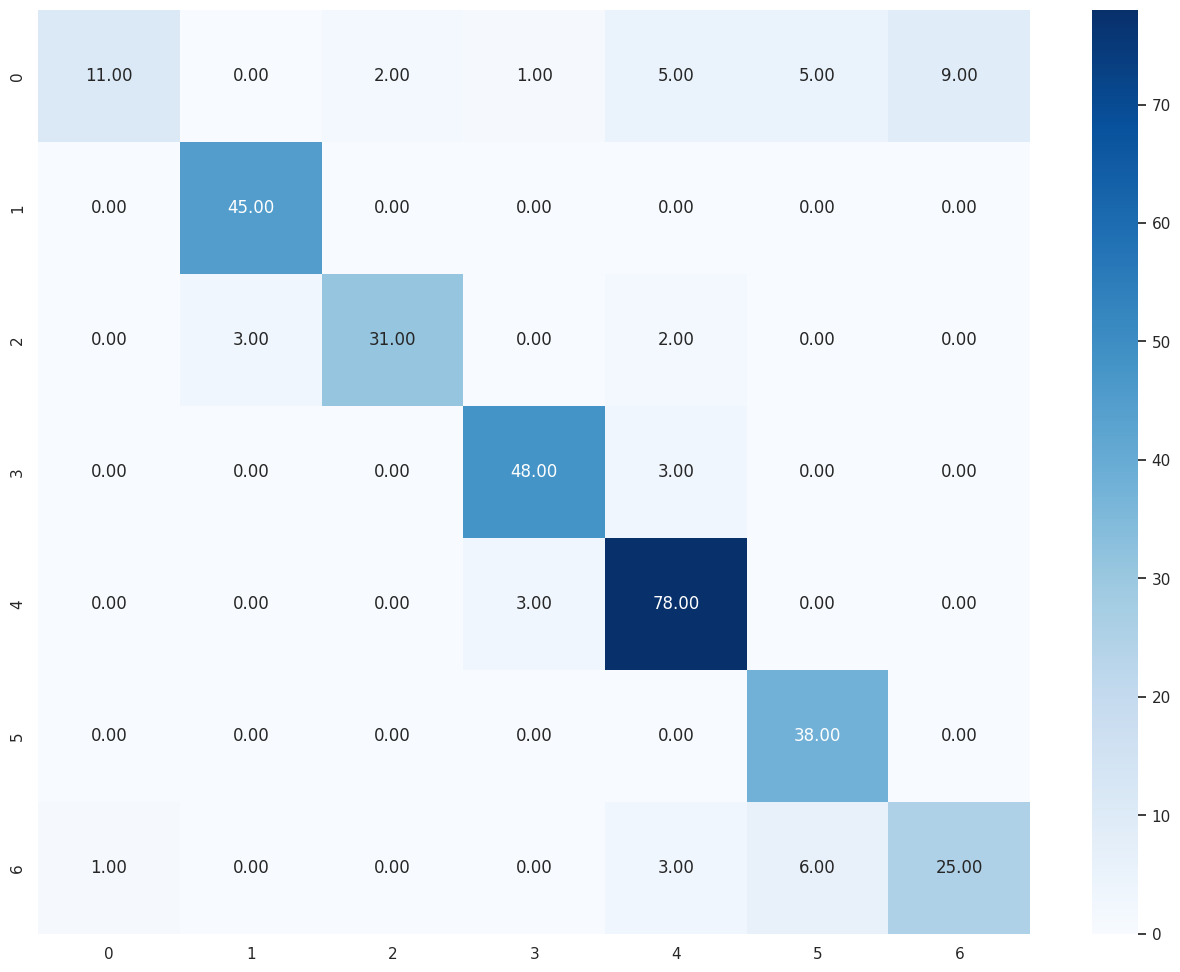

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(confusion_matrix(y_val_encoded, val_preds), cmap='Blues', annot=True, fmt=".2f")
plt.show()

In [ ]:
test_preds = lgb_model.predict(X_test_flat)
test_accuracy = accuracy_score(y_test_encoded, test_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(classification_report(y_test_encoded, test_preds))


Test Accuracy: 0.3232
Test Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.26      0.39        47
           1       1.00      0.29      0.44         7
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         8
           4       0.45      1.00      0.62        10
           5       0.11      0.44      0.18         9
           6       0.17      0.31      0.22        13

    accuracy                           0.32        99
   macro avg       0.36      0.33      0.27        99
weighted avg       0.53      0.32      0.32        99



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
joblib.dump(lgb_model, 'lgb_model.pkl')

['lgb_model.pkl']

In [ ]:
label_mapping

{0: np.str_('deadlift'),
 1: np.str_('hammer curl'),
 2: np.str_('lateral raise'),
 3: np.str_('plank'),
 4: np.str_('push-up'),
 5: np.str_('russian twist'),
 6: np.str_('squat')}

In [ ]:
seq_length

25

In [ ]:
overlap

13

In [ ]:
df_train.columns

Index(['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle',
       'right_knee_angle', 'left_hip_angle', 'right_hip_angle',
       'shoulder_angle', 'hip_angle', 'torso_angle',
       'right_hand_to_right_hip_dist', 'left_hand_to_left_hip_dist',
       'feet_distance', 'video_id', 'label'],
      dtype='object')